<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/09_milestone_project_2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NL P model to to make reading medical abstracts easier.
The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here:
https://arxiv.org/abs/1612.05251

**Resources** If you want to find the ground truth for this notebook(with lots of diagrams and text annotations) see the GitHub :
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to GPU


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a859e11b-8e31-ad55-8e43-e915cc796241)


## Get data
Since we'll be replicating the paper above(PubMed 200K RCT), let's download the dataset they use.
We can do so from the authors GitHub :
https://github.com/Franck-Dernoncourt/pubmed-rct


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
#! ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20K dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [6]:
# Check all of the filenames in the target directory 
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.
And one of the best ways to become one with the data is to....

> Visualize, Visualize, Visualize

So with that in mind, let's write a function to read all the lines of a target text file.

In [7]:
# Create function to read the lines of a document

def get_lines(filename) :
  """
  Reads filename(a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath.

  Returns :
  A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f :
    return f.readlines()


In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir  + "train.txt")
train_lines[:28]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented ...

```
[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines' : 11},
   ...]   
```

Let's write a function which turns each of our datasets into the above format, so we can continue to prepare our data for modelling.


In [10]:
def preprocess_text_with_line_numbers(filename) :
  """
  Returns list of dictionary of abstract line data.

  Takes in filename, reads it contents and sort through each line, 
  extracting things like the target label, text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target line
  for line in input_lines :

    if line.startswith("###") : # check to see if the line is an ID line
      abstract_id = line
      abstract_lines= "" # reset the abstract string if the line is an ID line

    elif line.isspace() : # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract lines into separate lines     
      # Iterate through each line in a single abstract and count at same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split) :
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data ={} # create an empty dictionar for each line
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear on the abstract
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the target abstract? (start from 0) 
        abstract_samples.append(line_data) # add line data to abstract samples list

    else : # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples



In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for val
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 543 ms, sys: 99.3 ms, total: 642 ms
Wall time: 653 ms


In [12]:
# Check the first abstract of our training  data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

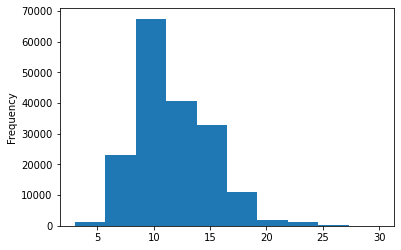

In [15]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [17]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML model requires numeric labels)

In [18]:
# One hot encode labels
# Sparse Matrix not applicable here , read more https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
## Label encode labels
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting  a series of modelling experiments...
As usual, we're going to be trying out a bunch of different models and seeing which one works best.
And as always, we're going to start with a baseline model (TF-IDF Multinomial Naive Bayes classifier).

Refer to the blog here for understanding ML concepts
https://chrisalbon.com/


## Model 0 : Getting a baseline model

We will learn machine learning experiments, we'll use SkLearn's Multinomial Naive Bayes using TF-IDF formula to convert words to numbers.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()), # Convert words to numbers using tdidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences, 
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
# EValuate baseline mdoel on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [23]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
In the previous modules, we wrote a function to compare predictions across different metrics(accuracy, precision, recall and f1)
and rather than rewriting it here, let's download from our helper function script : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-12 01:05:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-12 01:05:25 (87.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we'got to create vectorization and embedding layers.

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [28]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

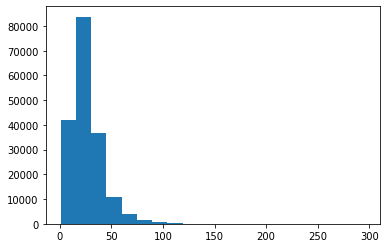

In [30]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# What percentile covers 95% of the sentence length
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Max sequence length in the training set
max(sent_lens)

296

### Create the TextVectorizer (tokenization)

We want to make a layer which maps our texts from words into numbers

In [33]:
# How many words are in our voab? (taken from table 2 in https://arxiv.org/pdf/1710.06071.pdf )
max_tokens = 68000

In [34]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Link to TextVectorization : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len, # desired output length of vectorized sequence
                                    standardize="lower_and_strip_punctuation", # default value
                                    split="whitespace", # default value
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # default  value                               
                                    pad_to_max_tokens = True) # default value
                                    

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
the purpose of this study was to prospectively evaluate the effect of benzyl alcohol , a common preservative in normal saline , on postprocedural pain after intraarticular injection for direct shoulder mr arthrography .

Length of text: 34

Vectorized text:[[    2   695     4    23    17    10     6  1125   164     2    70     4
  19112   461     8   317 18114     5   417   622    18  8383    65    21
   3944   390    11   982  1210  2078 10871     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary ?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab : {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab :v{rct_20k_text_vocab[-5:]}")

Number of words in vocab : 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab :v['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                             output_dim = 128, # Note: different embedding sizes result in drastically differnt number of params to train
                             mask_zero=True, # use masking to handle  variable sequence lengths(save space)
                             name="token_embedding")
token_embed

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization(before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the purpose of this study was to prospectively evaluate the effect of benzyl alcohol , a common preservative in normal saline , on postprocedural pain after intraarticular injection for direct shoulder mr arthrography .

Sentence after vectorization(before embedding):
 [[    2   695     4    23    17    10     6  1125   164     2    70     4
  19112   461     8   317 18114     5   417   622    18  8383    65    21
   3944   390    11   982  1210  2078 10871     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.03245487 -0.01846069 -0.00600249 ...  0.0167155  -0.01463555
   -0.0401637 ]
  [-0.00600662  0.037867   -0.02472319 ...  0.00555515 -0.04280237
   -0.00814886]
  [ 0.03378108  0.01388614 -0.01321529 ...  0.03479767  0.04074104
   -0.00492097]
  ...
  [-0.01003493  0.01993928 -0.02221539 ...  0.04435511  0.01777095
   -0.

## Creating datasets(making sure our data loads as fast as possible)
We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps are discussed at length in these 2 resources :

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [42]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [43]:
# Take the TensorSliceDataset's and turn them into prefetch dataset
# https://www.tensorflow.org/guide/data_performance#prefetching
# tf.data.AUTOTUNE - automatically prefetch as many samples as you can
# Dont run it more than once
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D with token embeddings

In [44]:
# Create 1D conv model to process sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype="string")
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)  # create embeddings
x = layers.Conv1D(filters = 64, # number of hidden units
                  kernel_size = 5, # take 5 words at a time n-gram = 5
                  strides=1, # default value
                  padding="same", # default value
                  activation="relu" 
                  )(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


In [45]:
# Compile model 1
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [46]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [47]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "milestone_project_experiments"

In [48]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [49]:
len(train_dataset)  * 32 #(batch size)

180064

In [50]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)), # only train on 10% of the total training batchs
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps =int(0.1 * len(valid_dataset))) # only validate on 10% of the batches


Epoch 1/3
562/562 [==============================] - 78s 83ms/step - loss: 0.9143 - accuracy: 0.6430 - val_loss: 0.6870 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 46s 81ms/step - loss: 0.6554 - accuracy: 0.7590 - val_loss: 0.6305 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 46s 82ms/step - loss: 0.6150 - accuracy: 0.7758 - val_loss: 0.5966 - val_accuracy: 0.7822


In [51]:
# Evaluate on whole dataset
results_model_1 = model_1.evaluate(valid_dataset)
results_model_1

945/945 [==============================] - 3s 3ms/step - loss: 0.5970 - accuracy: 0.7860


[0.596968948841095, 0.7859790921211243]

In [52]:
# Make predictions (our model predicts predictions probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5225713e-01, 1.6850576e-01, 5.5322174e-02, 2.9708314e-01,
         2.6831780e-02],
        [4.0689680e-01, 3.2864422e-01, 1.2219390e-02, 2.4340245e-01,
         8.8372258e-03],
        [1.1863870e-01, 5.8365725e-03, 1.3654378e-03, 8.7414235e-01,
         1.6971655e-05],
        ...,
        [1.0567532e-05, 9.5962628e-04, 1.0833720e-03, 5.7639459e-06,
         9.9794060e-01],
        [4.6627827e-02, 4.2916831e-01, 8.2496822e-02, 5.4624364e-02,
         3.8708270e-01],
        [1.7556843e-01, 7.0978886e-01, 4.2296413e-02, 3.6075506e-02,
         3.6270708e-02]], dtype=float32), (30212, 5))

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [54]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [55]:
# Calculate model_1_results = 
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.5979081159804,
 'f1': 0.7835175898238551,
 'precision': 0.7833618180638277,
 'recall': 0.7859790811598041}

In [59]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with later created USE pretrained embeddings.

More pretrained training models for all domains here 
https://huggingface.co/

In [66]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [65]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence :\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence :
 , when taught by school nurses and health education classroom teachers within a high school curricula .
Sentence after embedding:
[ 0.0639428   0.05611872  0.00438481  0.00400646 -0.04451676  0.08677963
 -0.03328352  0.06710973 -0.03013874  0.00110932  0.0567633  -0.03641367
 -0.05799257 -0.01818934  0.06803995  0.04106079 -0.08753001  0.04051477
  0.0030582  -0.08763402  0.01781769  0.03148479 -0.00236997 -0.07230731
  0.00131201 -0.02165015 -0.05852119 -0.04552792  0.04800659 -0.01626196]

Length of sentence embedding: 512


In [64]:
use_embedded_sentence.shape

TensorShape([1, 512])

### Building and fitting an NLP extraction mdoel using pretrained embeddings from Tensorflow Hub

In [70]:
# Define feature extraction model using TF Hub layer
from tensorflow.keras import layers

inputs = layers.Input(shape=[], dtype="string") # required empty list for pretrained layer
pretrained_embedding  = tf_hub_embedding_layer(inputs) # tokenize and embeddings of each sequence(512 long vectors)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note : you could add more layes here if you wanted to 
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [71]:
# Model summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [72]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9119 - accuracy: 0.6491 - val_loss: 0.7964 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7689 - accuracy: 0.7002 - val_loss: 0.7550 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7524 - accuracy: 0.7113 - val_loss: 0.7401 - val_accuracy: 0.7128


In [73]:
# Evaluate the model
results_model_2 = model_2.evaluate(valid_dataset)
results_model_2

945/945 [==============================] - 10s 11ms/step - loss: 0.7420 - accuracy: 0.7125


[0.7420307993888855, 0.7125314474105835]

In [76]:
# Make predictions with feature extraction mdoel
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

array([[4.26140666e-01, 3.69082987e-01, 2.40834453e-03, 1.95462123e-01,
        6.90584537e-03],
       [2.99811661e-01, 5.31646848e-01, 4.04548505e-03, 1.61941826e-01,
        2.55415309e-03],
       [2.22661972e-01, 1.62379056e-01, 1.99275743e-02, 5.59218824e-01,
        3.58126387e-02],
       [1.32023310e-02, 4.49675098e-02, 8.27391088e-01, 7.02954829e-03,
        1.07409522e-01],
       [3.66061591e-02, 2.25065023e-01, 2.17195749e-01, 1.60727482e-02,
        5.05060375e-01],
       [9.61861107e-04, 2.39150925e-03, 6.85543358e-01, 1.08686305e-04,
        3.10994595e-01],
       [2.02924083e-03, 3.19104991e-03, 6.36198819e-01, 1.05900539e-03,
        3.57521862e-01],
       [3.69989732e-03, 2.03090198e-02, 4.76695597e-01, 8.64736328e-04,
        4.98430789e-01],
       [6.55959419e-04, 7.28587713e-03, 1.83167346e-02, 1.12452835e-03,
        9.72616911e-01],
       [1.40896797e-01, 6.86809897e-01, 2.82252356e-02, 8.05342570e-02,
        6.35337904e-02]], dtype=float32)

In [77]:
# Convert the predictions probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [78]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)


In [79]:
model_2_results

{'accuracy': 71.25314444591552,
 'f1': 0.7095639099839991,
 'precision': 0.7122964073845975,
 'recall': 0.7125314444591553}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}